### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
from streamer import Streamer
from attack import Attacker
from edgearea import EdgeArea, IDS, VideoServer
from behavior import generate_attack_intensity, generate_hsmm
from environment import Environment
max_cpu = 6.0

### Define Environment

In [3]:
# Use the Solarize Light style globally
plt.style.use("Solarize_Light2")

# Set global parameters for black axes, labels, and grid
plt.rcParams['grid.color'] = 'white'               # Grid color
plt.rcParams['grid.linestyle'] = '--'              # Grid linestyle
plt.rcParams['grid.alpha'] = 0.7                   # Grid transparency
plt.rcParams['axes.edgecolor'] = 'black'           # Axis border color
plt.rcParams['axes.labelcolor'] = 'black'          # Axis label color
plt.rcParams['xtick.color'] = 'black'              # X-axis tick color
plt.rcParams['ytick.color'] = 'black'              # Y-axis tick color
plt.rcParams['text.color'] = 'black'               # Default text color, affects title color

In [4]:

atk_states = ["NoAtk", "DDoS", "SYN Flood", "HTTP Flood"]
atk_states = ["NoAtk", "bonesi", "goldeneye", "hulk"]
# atk_states = ["NoAtk", "bonesi", "bonesi", "bonesi"]
atk_duration_means = [5, 3, 2, 4]  # mean duration for each state (Poisson distribution)
atk_transition_matrix = np.array([[0.6, 0.1, 0.15, 0.15],  # No Attack
                            [0.3, 0.5, 0.1, 0.1],  # DDoS
                            [0.3, 0.1, 0.5, 0.1],  # SYN Flood
                            [0.3, 0.1, 0.2, 0.4]])  # HTTP Flood   

stream_states = [0, 1] #0: Idle, #1: Streaming
stream_duration_means = [20, 30]  # mean duration for each state (Poisson distribution)
stream_transition_matrix = np.array([[0.3, 0.7],  # Idle
                                     [0.8, 0.2]])  # Streaming
# stream_transition_matrix = np.array([[0.0, 1.0],  # Idle
#                                      [0.0, 1.0]])  # Streaming

# Attack Intensity Parameters
baseline_intensity = 700
fluctuation_intensity = 60
spike_prob = 0.0
spike_intensity = 200
persistence_coeffs = [0.85, 0.15, 0.0]  # Weights for AR(3)
decay_factor = 0.00 # Decay factor to bring intensity down gradually
drop_prob = 0.00  # Probability of a sudden drop in intensity
drop_intensity = 100  # Amount by which intensity drops if drop event occurs

In [5]:

# import numpy as np
# class Environment:
#     def __init__(self, run_for=100, cpu_capacity = 3.0, atk_state="bonesi", seed=4022):
#         self.qoe_list = []  # Store QoE values over time
#         self.user_count_list = []
#         self.cpu_decision_list = []
#         self.area_dict = {}
#         #TODO Model Streamer Interactions with server (Arrival And Departure)
#         self.seed = seed  # Seed for reproducibility
#         np.random.seed(self.seed)
#         random.seed(self.seed)
#         self.cpu_allocated = cpu_capacity
#         self.current_timestep = 0  # Initialize timestep counter
#         self.run_for = run_for  # Total number of timesteps to simulate
#         self.atk_state = atk_state
#     def initialize_agent(self, num_area, num_streamers, num_attackers):
#         # num_area=3
#         # num_streamers= [6, 6, 6] #Depending on num_server
#         # num_attackers= [2, 1, 2] #Depending on num_attackers
#         num_streamers = [num_streamers]
#         num_attackers = [num_attackers]
#         for i in range(num_area): #Initialize Edge Area Servers
#             video_cpu = self.cpu_allocated
#             streamers = []
#             attackers = []
#             aggregate_state_sequence = np.zeros(self.run_for)  
#             for j in range(num_streamers[i]): #Initialize streamers
#                 hsmm_states = generate_hsmm(self.run_for, stream_states, stream_duration_means, stream_transition_matrix)

#                 streamers.append(Streamer(j, hsmm_states))     
#                 aggregate_state_sequence += hsmm_states
#             self.user_count_list = aggregate_state_sequence    
                 
#             for j in range(num_attackers[i]): #Initialize Attackers
#                 hsmm_states = generate_hsmm(self.run_for, atk_states, atk_duration_means, atk_transition_matrix, plot=False)
#                 intensity_sequence = generate_attack_intensity(
#                         self.run_for, baseline_intensity, fluctuation_intensity, spike_prob, spike_intensity,
#                         persistence_coeffs, decay_factor, drop_prob, drop_intensity
#                 )                
#                 attackers.append(Attacker(j, intensity_sequence, hsmm_states))
#             # Define the Streamer/Attacker-Server Relation on Environment for Task Offloading
#             self.area_dict[i] = {
#                                           "area": EdgeArea(video_cpu),
#                                         #   "server": VideoServer(video_cpu), 
#                                           "streamers": streamers, #TODO: When Task Offload, put streamers on seperate list
#                                           "attackers": attackers, #Attack Workers
#                                           }
#     def calculate_qoe(self): # Run One Timestep and Calculate QoE
#         total_qoe = 0
#         num_users = 0
#         for _, edge_area in self.area_dict.items():
#             cur_server, streamers, attackers = edge_area['area'].server, edge_area['streamers'], edge_area['attackers']
#             for streamer in streamers: #Initiate the Streaming Task
#                 if streamer.state == 1:
#                     streamer.start_stream(cur_server) 
#             for attack in attackers: #Initiate the Attack Task
#                 attack.start(cur_server) #IDS is Called Here
#             total_qoe += cur_server.calculate_qoe() 
#         average_qoe = total_qoe / len(self.area_dict) 
#         self.qoe_list.append(average_qoe)

#     def resource_decision(self): #TODO: Change to Control Node
#         for _, edge_area in self.area_dict.items():
#             # vim = edge_area['area'].vim
#             # vim.resource_decision()
#             server = edge_area['area'].server
#             server.query_resource_decision()

#     def start_new_timestep(self):
#         #? Update Agent
#         for _, edge_area in self.area_dict.items():
#             edge_area['area'].forward()
#             for attack in edge_area['attackers']: #Initiate the Attack Task
#                 attack.forward() #IDS is Called Here           
#             for streamer in edge_area['streamers']:
#                 streamer.forward()
#         self.current_timestep += 1
#     def start_new_timestep_controled(self, intensity):
#         for _, edge_area in self.area_dict.items():
#             edge_area['area'].forward()
#             for attack in edge_area['attackers']: #Initiate the Attack Task
#                 attack.forward_controlled(self.atk_state, intensity) #IDS is Called Here   
                
#             for streamer in edge_area['streamers']:
#                 streamer.forward()    
#                 streamer.state = 1

#     def update_timestep(self):
#         self.calculate_qoe()
#         self.resource_decision()
#         self.start_new_timestep()
#         # self.start_new_timestep_controled()
    
#     def plot_qoe(self, ma_window_size = 10):
#         def calculate_moving_average(data, window_size=10):
#             """
#             Calculates the moving average of the given data over a specified window size.
#             """
#             return np.convolve(data, np.ones(window_size) / window_size, mode='valid')        
#         qoe_moving_avg = calculate_moving_average(np.array(self.qoe_list), ma_window_size)
#         print("Mean QoE", np.mean(self.qoe_list[len(self.qoe_list)-500:]))
#         # Plot QoE and number of users over time
#         fig, ax1 = plt.subplots(figsize=(20, 6))

#         # Plot QoE
#         ax1.set_xlabel("Timestep")
#         ax1.set_ylabel("QoE", color="tab:blue")
#         ax1.plot(self.qoe_list, label="QoE", color="tab:blue", linewidth=1.5, marker="o")
#         # ax1.plot(range(ma_window_size-1,len(self.qoe_list)), qoe_moving_avg, label=f"QoE MA {ma_window_size}", color="tab:green", linewidth=3)
#         ax1.set_ylim(-0.05,1.05)
#         ax1.tick_params(axis="y", labelcolor="tab:green")
#         ax1.legend()

#         # Create a second y-axis to plot number of users
#         ax2 = ax1.twinx()
#         ax2.set_ylabel("Number of Active Users", color="tab:orange")
#         ax2.plot(self.user_count_list, label="Active Users", color="tab:orange", linewidth=2)
#         ax2.tick_params(axis="y", labelcolor="tab:orange")
#         ax2.legend()
        
#         # Overlay state sequence if provided
#         try:
#             state_sequence = self.area_dict[0]["attackers"][0].hsmm_state
#             ax3 = ax1.twinx()  # Create a third y-axis for state sequence
#             ax3.spines["right"].set_position(("outward", 60))  # Offset the third axis
#             ax3.set_yticks(range(len(set(state_sequence))))  # Set y-ticks based on unique states
#             ax3.set_yticklabels(set(state_sequence), rotation=90)  # Label the states
            
#             ax3.plot(state_sequence, label="HSMM States", color="tab:red", marker='o', linestyle='None')
#             ax3.set_yticks(range(len(atk_states)))  # Set y-ticks based on the number of states
#             ax3.set_yticklabels(atk_states, rotation=90)  # Set the attack state labels
#             ax3.set_ylabel("Attack State", color="tab:red")
#             ax3.tick_params(axis="y", labelcolor="tab:red")
#             ax3.legend(loc="upper center")        


#             ax3.set_xlim(max(0, len(self.qoe_list) - 500), len(self.qoe_list))      

#         except:
#             pass
#         ax1.set_xlim(max(0, len(self.qoe_list) - 500), len(self.qoe_list))      
#         ax2.set_xlim(max(0, len(self.qoe_list) - 500), len(self.qoe_list))      
#         # Add legends and title
#         fig.suptitle("QoE and Number of Active Users Over Time")
#         fig.tight_layout()
#         plt.legend()
#         plt.show()        
#         print(len(self.qoe_list))

#     def run(self, intensity=0):
#         for _ in range(self.run_for):
#             # self.update_timestep()            
#             self.calculate_qoe()
#             self.start_new_timestep_controled(intensity)            
#             if self.current_timestep >= self.run_for-1:
#                 for _, edge_area in self.area_dict.items():
#                     edge_area["area"].vim.previous_info.to_csv("previous_info.csv")
#                     q_table_data = []
#                     for state, q_values in edge_area["area"].vim.agent.q_table.items():
#                         state_data = {
#                             "state": state,
#                             **{f"action_{i}": q_value for i, q_value in enumerate(q_values)}
#                         }
#                         q_table_data.append(state_data)    
#                         q_table_df = pd.DataFrame(q_table_data)
#                         q_table_df.to_csv("qtable.csv", index=False)                                        
#                 break         
#         return self.qoe_list

/home/vincent/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vincent/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/vincent/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vincent/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/vincent/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported

Simulation Complete.
Mean QoE 0.8862034391393699


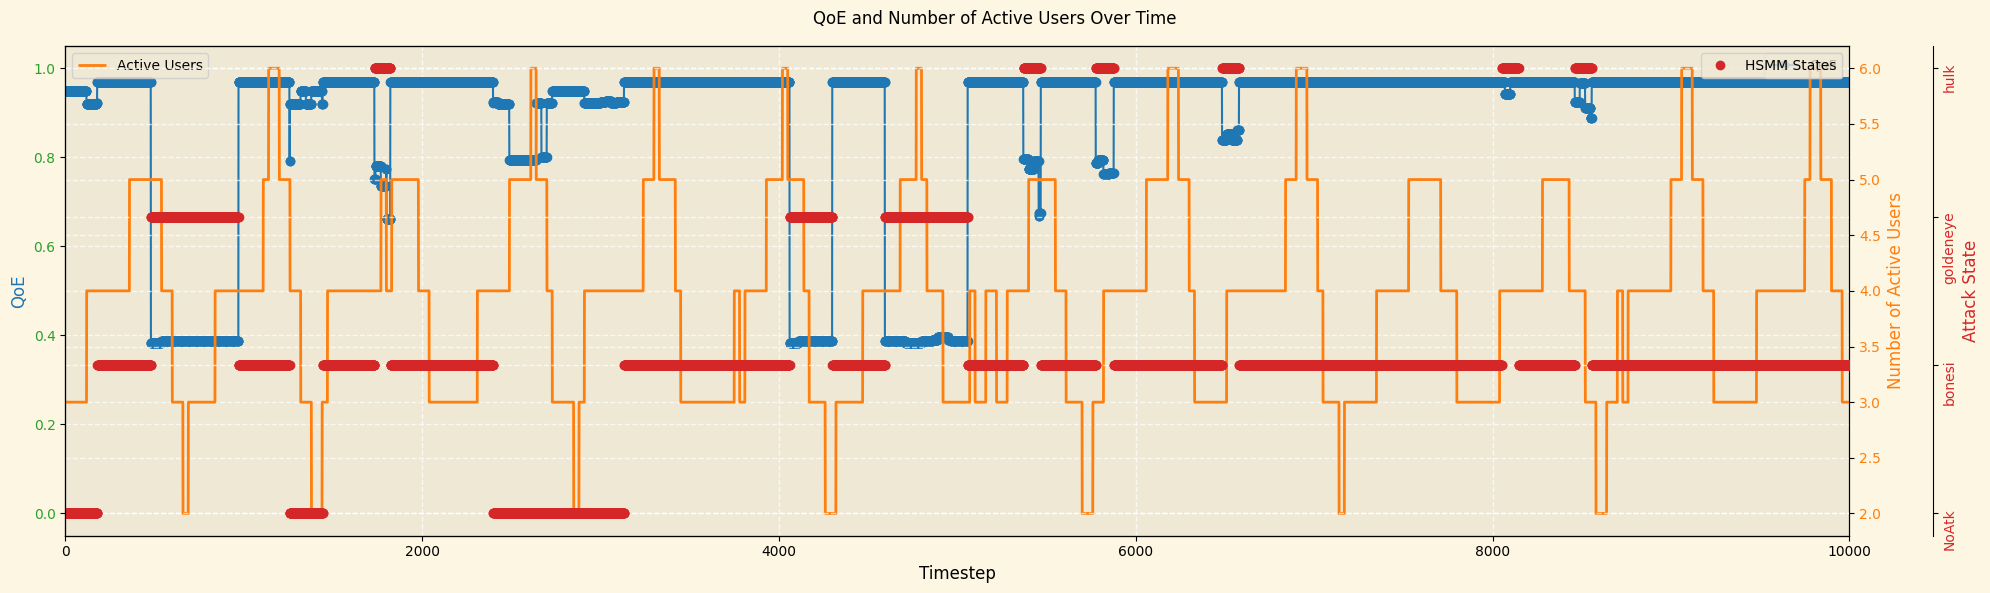

10000
Mean QoE 0.9111789346646055


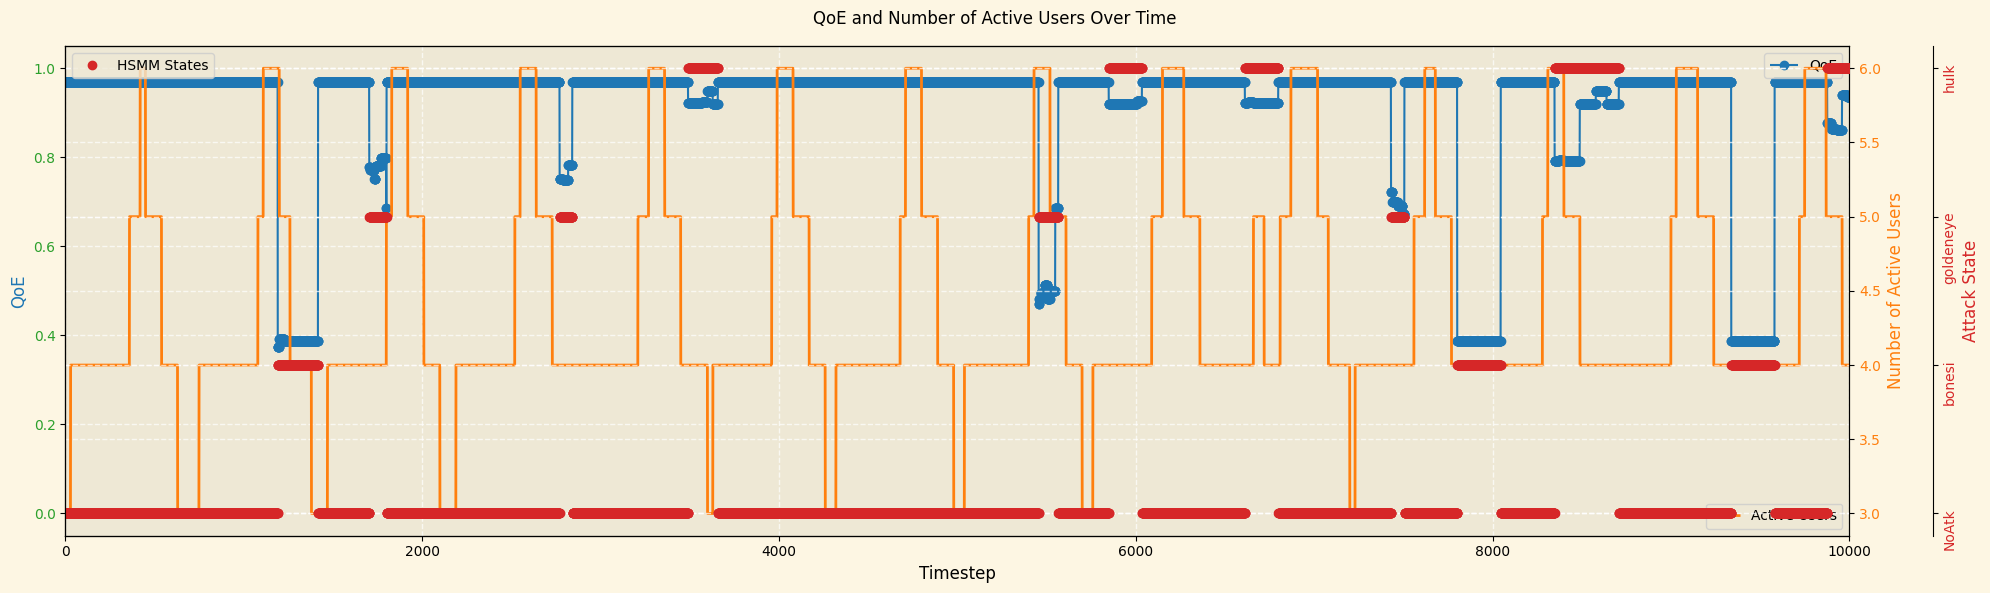

10000
Mean QoE 0.9191506588365315


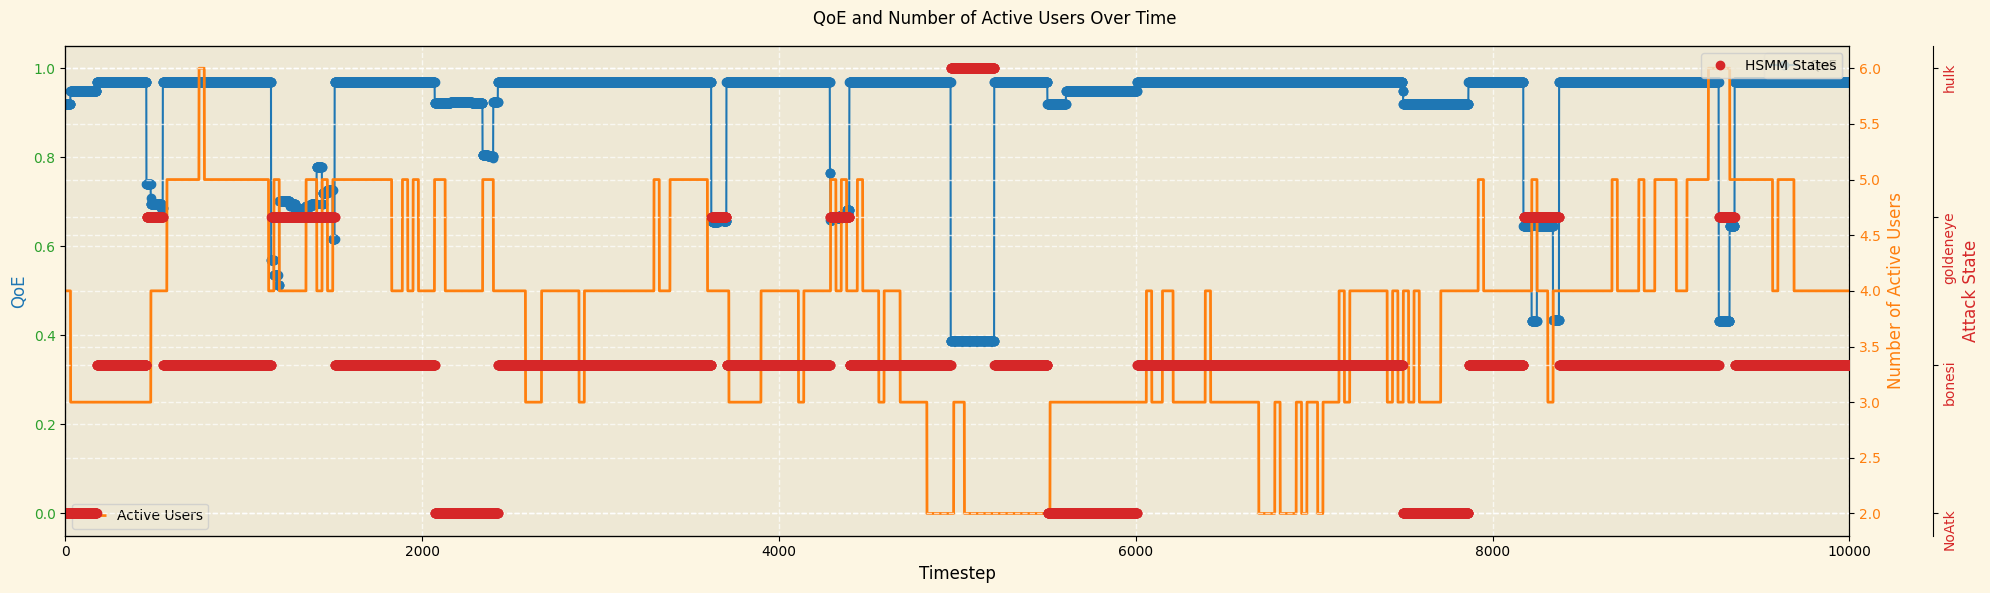

10000


In [10]:
env = Environment(run_for=10000, cpu_capacity = 5.5)
env.initialize_agent(num_area=3, num_streamers=6, num_attackers=1)
env.run()
env.plot_qoe(ma_window_size=5)


### BaseLine - Discrete Approximation Resource Allocation

Generate the resource allocation dictionary

In [8]:
# Define parameters for brute-force search
cpu_range = np.arange(0.5, max_cpu, 0.5)  # Range of CPU allocations to test
streamer_range = range(0, 7)  # Range of streamer numbers to test (1 to 6)
intensity_min, intensity_max, intensity_interval= 0, 2200, 200  # Continuous range for intensity

# Sample intensities within the continuous range
intensity_samples = np.arange(intensity_min, intensity_max, intensity_interval)

# Dictionary to store the best QoE results
best_results = {}

# Perform brute-force search over CPU, number of streamers, and sampled intensities
for atk_state in ["goldeneye"]:
# for atk_state in atk_states:
    # print(atk_state)
    for intensity in intensity_samples:
        for n_streamers in streamer_range:
            max_qoe = 0
            best_cpu = 5.5

            for cpu in cpu_range:
                # Initialize the environment for each combination of CPU, streamers, and intensity
                env = Environment(run_for=2, cpu_capacity=cpu, atk_state=atk_state)
                env.initialize_agent(num_area=1, num_streamers=n_streamers, num_attackers=1)
                
                # Run the environment and get the QoE for the current intensity
                cur_qoe = env.run(intensity=intensity)[1]
                
                # Update the maximum QoE and the best CPU allocation if this QoE is higher
                if cur_qoe > max_qoe:
                    max_qoe = cur_qoe
                    best_cpu = cpu

            # Store the best CPU, max QoE, and intensity for this combination of streamers and intensity
            best_results[(round(intensity, 2), n_streamers)] = {"best_cpu": best_cpu, "max_qoe": max_qoe}
            # best_results[(atk_state,round(intensity, 2), n_streamers)] = {"best_cpu": best_cpu, "max_qoe": max_qoe}

    # Display the results
    print(f"Best CPU Allocation for Maximum QoE with Sampled Continuous Intensity for {atk_state}:")
    for (intensity, n_streamers), result in best_results.items():
    # for (atk_state, intensity, n_streamers), result in best_results.items():
        print(f"Attack: {atk_state} | Intensity: {intensity} | Streamers: {n_streamers} | Best CPU: {result['best_cpu']} | Max QoE: {result['max_qoe']}")

Best CPU Allocation for Maximum QoE with Sampled Continuous Intensity for goldeneye:
Attack: goldeneye | Intensity: 0 | Streamers: 0 | Best CPU: 0.5 | Max QoE: 1.0
Attack: goldeneye | Intensity: 0 | Streamers: 1 | Best CPU: 5.5 | Max QoE: 0.9699999999791463
Attack: goldeneye | Intensity: 0 | Streamers: 2 | Best CPU: 5.5 | Max QoE: 0.9699999999794742
Attack: goldeneye | Intensity: 0 | Streamers: 3 | Best CPU: 5.5 | Max QoE: 0.9699999844747067
Attack: goldeneye | Intensity: 0 | Streamers: 4 | Best CPU: 5.5 | Max QoE: 0.9699769989122802
Attack: goldeneye | Intensity: 0 | Streamers: 5 | Best CPU: 5.5 | Max QoE: 0.9698747176163082
Attack: goldeneye | Intensity: 0 | Streamers: 6 | Best CPU: 5.5 | Max QoE: 0.9697231820718027
Attack: goldeneye | Intensity: 200 | Streamers: 0 | Best CPU: 0.5 | Max QoE: 1.0
Attack: goldeneye | Intensity: 200 | Streamers: 1 | Best CPU: 5.0 | Max QoE: 0.9699999997607165
Attack: goldeneye | Intensity: 200 | Streamers: 2 | Best CPU: 5.0 | Max QoE: 0.9699999997269881

In [9]:
atk_states

['NoAtk', 'bonesi', 'goldeneye', 'hulk']

Convert to Json File

In [10]:
# Convert dictionary to a JSON-serializable format
best_results_serializable = {
    str(k): {key: float(value) if isinstance(value, np.float64) else value for key, value in v.items()}
    for k, v in best_results.items()
}
import json
# Save the dictionary as a JSON file
# with open("./DARA_6.0.json", "w") as file:
    # json.dump(best_results_serializable, file)
# with open("./Optimal_12.0.json", "w") as file:
#     json.dump(best_results_serializable, file)

In [11]:
def discrete_approx_decision(intensity, n_streamer):
    with open("DARA.json", "r") as file:
        best_approx_decision_dict = json.load(file)
    closest_intensity = int(intensity/intensity_interval)*intensity_interval
    return best_approx_decision_dict[str((closest_intensity, n_streamer))]
    
discrete_approx_decision(500, 2)['best_cpu']


8.0

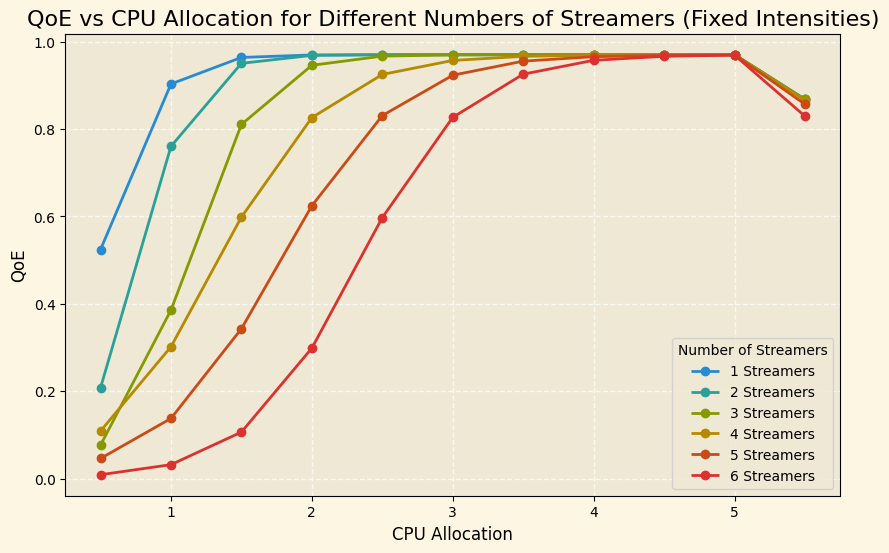

In [12]:
# for intensity in range(100,5000):
results = {}

# Iterate over different numbers of streamers
for n_streamers in range(1, 7):
    qoe_list = []
    cpu_allocations = np.arange(0.5, max_cpu, 0.5)
    
    # Iterate over CPU allocations from 0.5 to 5.5 in steps of 0.5
    for cpu in cpu_allocations:
        env = Environment(run_for=2, cpu_capacity=cpu, atk_state="bonesi")
        env.initialize_agent(num_area=1, num_streamers=n_streamers, num_attackers=1)
        cur_qoe = env.run(intensity=200)[1]
        qoe_list.append(cur_qoe)

    # Store QoE list in results dictionary for plotting
    results[n_streamers] = qoe_list

# Plotting
plt.figure(figsize=(10, 6))

# Plot each QoE line for different numbers of streamers
for n_streamers, qoe_list in results.items():
    plt.plot(cpu_allocations, qoe_list, marker='o', label=f'{n_streamers} Streamers')

# Labeling the plot
plt.title('QoE vs CPU Allocation for Different Numbers of Streamers (Fixed Intensities)')
plt.xlabel('CPU Allocation')
plt.ylabel('QoE')
plt.legend(title='Number of Streamers')
plt.grid(True)

# Show the plot
plt.show()

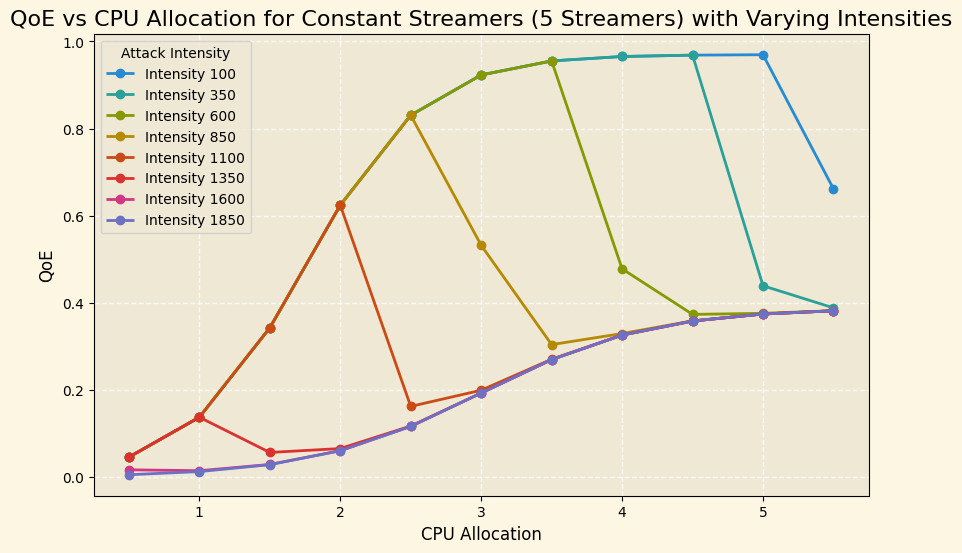

In [13]:
# Set constant parameters
n_streamers = 5  # Constant number of streamers
cpu_allocations = np.arange(0.5, max_cpu, 0.5)  # Range of CPU allocations
intensity_range = range(100, 2000, 250)  # Range of attack intensities

# Dictionary to store QoE results for each intensity level
results = {}

# Iterate over different intensities
for intensity in intensity_range:
    qoe_list = []
    
    # Iterate over CPU allocations from 0.5 to 5.5 in steps of 0.5
    for cpu in cpu_allocations:
        # Initialize environment with current CPU and constant streamers
        env = Environment(run_for=2, cpu_capacity=cpu, atk_state="hulk")
        env.initialize_agent(num_area=1, num_streamers=n_streamers, num_attackers=1)
        
        # Run the environment with current intensity and get QoE
        cur_qoe = env.run(intensity=intensity)[1]
        qoe_list.append(cur_qoe)
        

    # Store QoE list in results dictionary for plotting
    results[intensity] = qoe_list

# Plotting
plt.figure(figsize=(10, 6))

# Plot each QoE line for different attack intensities
for intensity, qoe_list in results.items():
    plt.plot(cpu_allocations, qoe_list, marker='o', label=f'Intensity {intensity}')

# Labeling the plot
plt.title(f'QoE vs CPU Allocation for Constant Streamers ({n_streamers} Streamers) with Varying Intensities')
plt.xlabel('CPU Allocation')
plt.ylabel('QoE')
plt.legend(title='Attack Intensity')
plt.grid(True)

# Show the plot
plt.show()

## QoE Distribution Without Attacks

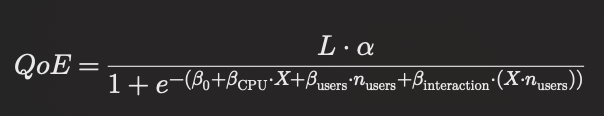

In [14]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

# def logistic(X, beta_0, beta_1):
#     L = 0.85  
#     return L / (1 + np.exp(-(beta_0 + beta_1 * X)))

# # Parameters for different numbers of users
# qoe_vs_n_user_params = {
#     1: [-6.1664922,   7.32642948],
#     2: [-2.69486035,  2.53728771],
#     3: [-2.23382782,  1.16795435],
#     4: [-3.02220136,  1.29189061],
#     5: [-2.95189246,  1.25219137],
#     6: [-2.90428219,  0.94603565],
#     }
def generalized_logistic(X, L, alpha, beta_0, beta_CPU, beta_CPU_squared, beta_users, beta_interaction, n_users,atk):
    # Logistic function calculation with the specified regression equation
    linear_combination = (
        beta_0 
        + beta_CPU * X 
        # + beta_CPU_squared * (X ** 2) 
        + -1.5 * n_users #Increasing user will have negative effect on QoE
        + beta_interaction * (X * n_users) #Negative: diminishing return on CPU as the number of users increases
    )
    if atk == "none":
        L = 0.95
        L*(1-alpha*n_users)
    else:
        L = L*(1-alpha*n_users)
    # return L*(1-alpha*n_users) / (1 + np.exp(-linear_combination))
    return L / (1 + np.exp(-linear_combination))


def calculate_qoe(X, n_user,atk):
    """
    Calculates the QoE based on CPU allocation (X) and the number of users (n_user).
    """
    # params = qoe_vs_n_user_params[n_user]
    params = qoe_vs_n_user_params
    return generalized_logistic(X, *params, n_user, atk=atk)
def plot_qoe_distribution(qoe_vs_n_user_params, std_matrix,atk="none"):
    # Plotting setup
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # 2 rows and 3 columns
    cpu_list = np.arange(0.5, 6, 0.5)  # Range of CPU values
    n_user_list = np.arange(1, 7)  # User counts from 1 to 6

    # Loop through each number of users to plot the QoE vs CPU
    for n_user in n_user_list:
        ax = axes[(n_user - 1) // 3, (n_user - 1) % 3]
        
        # Calculate QoE for each CPU value
        X = np.tile(cpu_list,(1000,1)).flatten()
        std_dev = [np.random.normal(0,std_matrix[n_user-1][int(i*2-1)]) for i in X]
        y = calculate_qoe(X, n_user,atk=atk) + std_dev
        y = np.clip(y,0,1)
        # Density estimation for color coding
        xy = np.vstack([X, y])
        density = gaussian_kde(xy)(xy)
        
        # Scatter plot with density-based colors
        sc = ax.scatter(X, y, c=density, s=density * 200, cmap='plasma', alpha=0.7)
        
        # Plot the logistic fit line
        ax.plot(cpu_list, calculate_qoe(cpu_list, n_user,atk=atk), color='black', linestyle='--', label='Logistic Fit')
        
        # Labels and titles for each subplot
        ax.set_xlabel('CPU')
        ax.set_ylabel('QoE')
        ax.set_xlim(0.4, 6)
        ax.set_ylim(0, 1)
        ax.set_title(f'{n_user} User(s)')
        ax.legend()

    # Colorbar for the density plot
    fig.colorbar(sc, ax=axes.ravel().tolist(), orientation='horizontal', label='Density')
    fig.suptitle('Density Map of QoE vs CPU for Users 1 to 6')
    plt.show()
# def attack_impact()



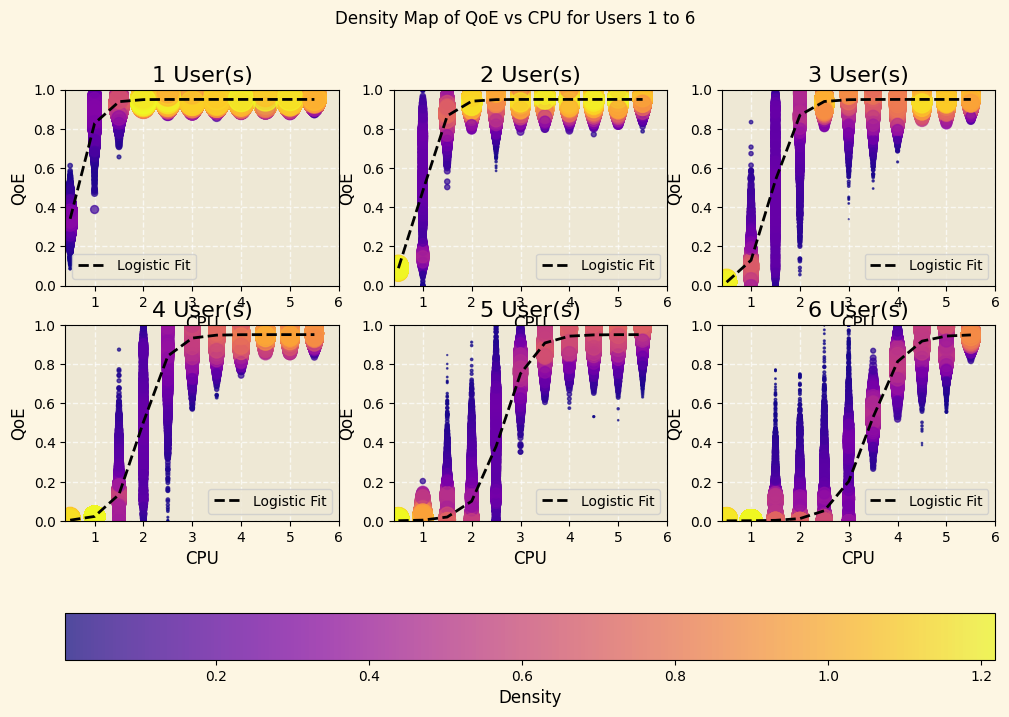

KeyboardInterrupt: 

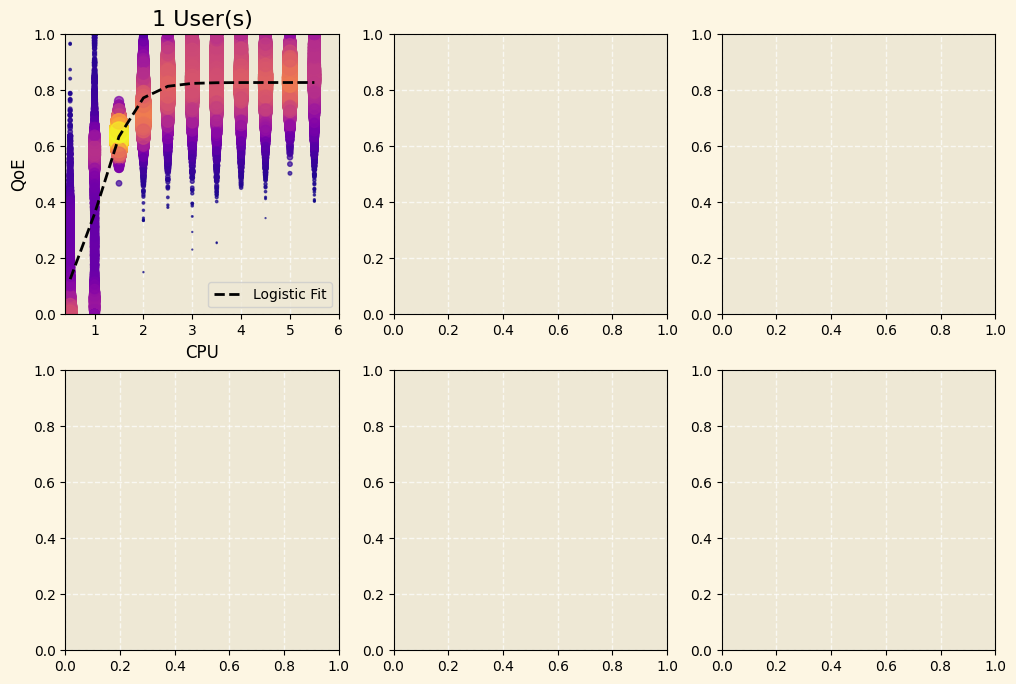

In [15]:
qoe_vs_n_user_params = [0.9527590553836042, 0.012356370194565059, -1.5753511198691, 5.370248138166865, -470.47100057345574, -0.8539269983355553, -0.38043183206411557]
#                       "L,     alpha,                  beta_0,                 beta_CPU,       beta_CPU_squared,  beta_users, beta_interaction"


std_matrix = [ # [User] [CPU * 2]
            [0.0902, 0.1282, 0.0794, 0.0151, 0.0227, 0.0241, 0.0221, 0.0205, 0.0205, 0.0205, 0.0205],
            [0.0050, 0.2217, 0.1078, 0.0451, 0.1111, 0.0493, 0.0493, 0.0493, 0.0493, 0.0493, 0.0493 ],
            [0.0050, 0.1800, 0.2824, 0.2959, 0.0377, 0.1578, 0.1578, 0.0964, 0.0364, 0.0364, 0.0348 ],
            [0.0050, 0.0000, 0.2355, 0.3006, 0.2886, 0.1364, 0.0975, 0.0629, 0.0325, 0.0325, 0.0325 ],
            [0.0050, 0.0478, 0.2645, 0.2917, 0.2898, 0.1224, 0.1113, 0.1113, 0.1113, 0.1113, 0.1113 ],
            [0.0050, 0.0000, 0.2680, 0.2680, 0.3473, 0.3473, 0.0956, 0.0956, 0.1527, 0.1527, 0.0387 ],
            ]
plot_qoe_distribution(qoe_vs_n_user_params, std_matrix,atk="none")
qoe_vs_n_user_params = [0.8497987262580884, 0.025954251123661228, -1.6793767808047577, 2.9774201662483755, -2355.033784310665, -0.71314329861917, -0.06426909430225365]
std_matrix = [
    [0.2571, 0.3391, 0.0421, 0.1339, 0.1339, 0.1621, 0.1621, 0.1470, 0.1470, 0.0971, 0.1573 ],
    [0.0000, 0.1678, 0.0547, 0.1975, 0.1975, 0.1055, 0.1055, 0.1334, 0.1334, 0.1319, 0.1409 ],
    [0.0000, 0.2132, 0.1842, 0.2146, 0.2146, 0.0435, 0.1451, 0.1451, 0.2314, 0.1161, 0.1095 ],
    [0.0000, 0.0000, 0.2698, 0.2698, 0.0964, 0.1292, 0.1292, 0.1378, 0.1265, 0.1265, 0.1943 ],
    [0.0000, 0.0000, 0.1611, 0.1611, 0.1826, 0.1586, 0.1586, 0.1218, 0.1149, 0.1149, 0.1786 ],
    [0.0000, 0.0000, 0.1544, 0.1544, 0.2106, 0.1976, 0.1976, 0.2186, 0.1769, 0.1769, 0.1373 ],    
]
plot_qoe_distribution(qoe_vs_n_user_params, std_matrix,atk="bonesi")

## Attack Impact Regression

0.97 -5.935 2.563
0.9392917333695271 -6.561300901896415 2.1573026424025663
0.9247861753206386 -6.857144499903813 1.9656647801381277
0.9146976073790096 -7.062902749847345 1.832381276868051
0.9118321895103426 -7.121343488852634 1.794525266572207
0.911800017803515 -7.121999636893945 1.7941002352082942
0.9118000000000054 -7.121999999999889 1.7941000000000722
0.9117999999999999 -7.121999999999999 1.7941
0.9117999999999999 -7.121999999999999 1.7941
0.9117999999999999 -7.121999999999999 1.7941
0.9117999999999999 -7.121999999999999 1.7941


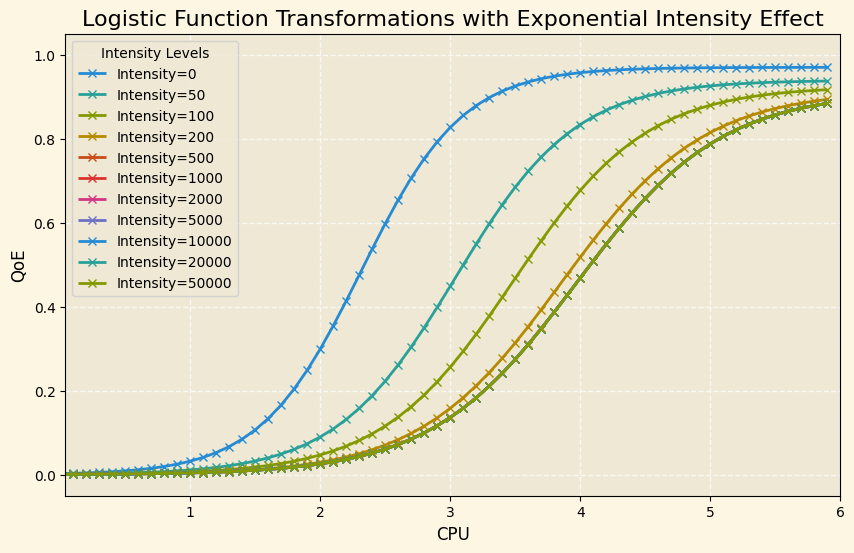

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
'''
0,1,0.97, -2.2782716980482065, 4.8802368476587255
0,2,0.97, -3.8873078667967476, 5.175670954212056
0,3,0.97, -4.4959769724864636, 4.081147830542201
0,4,0.97, -3.3377765392197962, 2.5431386672697025
0,5,0.97, -4.186919060489949, 2.3893219975556157
0,6,0.97, -5.935630098896784, 2.56309746149014
'''

# Define the modified logistic function with exponential effect from intensity
def logistic(x, intensity, L_base=0.97, k=1.0, beta_0=-5.935, beta_CPU_base=2.563, alpha=0.015): #Follow The Regression Params from 0 Intensity
    # Define exponential saturation adjustment for intensity effect
    intensity_effect = 1 - np.exp(-alpha * intensity)
    
    # Adjust parameters based on intensity effect
    L = L_base * (1 - 0.06 * intensity_effect)  # Decrease L with intensity effect (saturates at ~0.5*L_base)
    beta_0 = beta_0 * (1 + 0.2 * intensity_effect)  # Decrease beta_CPU similarly
    beta_CPU = beta_CPU_base * (1 - 0.3 * intensity_effect)  # Decrease beta_CPU similarly
    print(L, beta_0, beta_CPU)
    return L / (1 + np.exp(-(beta_0 + beta_CPU * x)))

# Define the x values
x_values = np.arange(0, max_cpu, 0.1)

# Define intensity levels for each curve (including high levels close to saturation)
intensity_levels = [0, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000]  # Increasing intensity up to saturation point

# Plot each curve with different intensity levels
plt.figure(figsize=(10, 6))
for intensity in intensity_levels:
    y_values = logistic(x_values, intensity)
    plt.xlim(0.04,max_cpu)
    plt.plot(x_values, y_values, marker="x", label=f"Intensity={intensity}")

plt.xlabel("CPU")
plt.ylabel("QoE")
plt.title("Logistic Function Transformations with Exponential Intensity Effect")
plt.legend(title="Intensity Levels")
plt.ylim(-0.05, 1.05)
plt.show()

### Attack Intensity Modeling

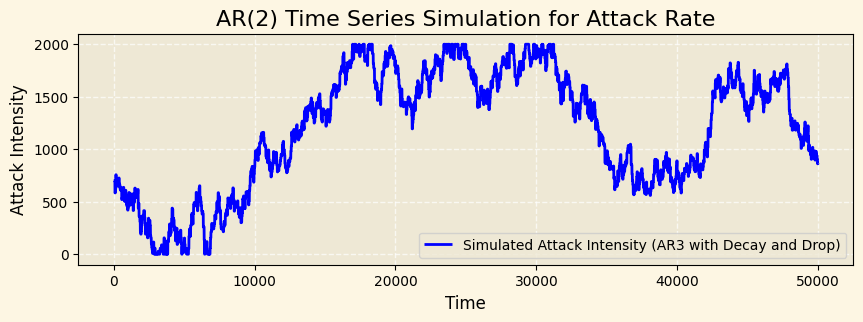

In [38]:
import numpy as np
import matplotlib.pyplot as plt
# np.random.seed(4022)


# Parameters
time_steps = 50_000
baseline_intensity = 700
fluctuation_intensity = 60
spike_prob = 0.0
spike_intensity = 200
persistence_coeffs = [0.85, 0.15, 0.0]  # Weights for AR(3)
decay_factor = 0.00 # Decay factor to bring intensity down gradually
drop_prob = 0.00  # Probability of a sudden drop in intensity
drop_intensity = 100  # Amount by which intensity drops if drop event occurs

# Generate intensity pattern for attack with AR(3), decay, and drop probability
intensity_series = generate_attack_intensity(
    time_steps, baseline_intensity, fluctuation_intensity, spike_prob, spike_intensity,
    persistence_coeffs, decay_factor, drop_prob, drop_intensity
)

# Plot results
plt.figure(figsize=(10, 3))
plt.plot(intensity_series[:50000], label="Simulated Attack Intensity (AR3 with Decay and Drop)", color="blue")
plt.xlabel("Time")
plt.ylabel("Attack Intensity")
plt.title("AR(2) Time Series Simulation for Attack Rate")
plt.legend()
plt.show()

In [36]:
np.ceil(1.5).astype(int)

2

### Attacker States

Before

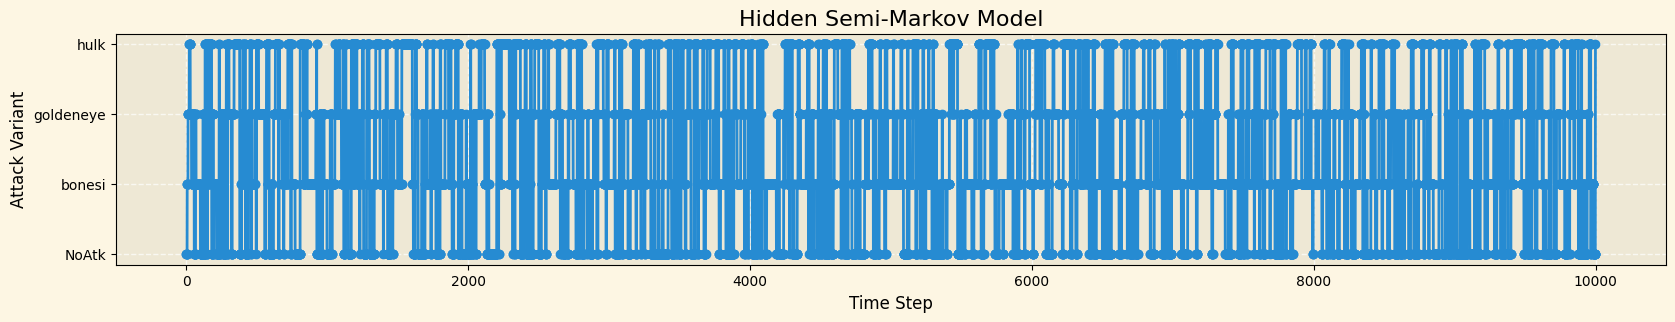

In [16]:
run_for=10_000
atk_states = ["NoAtk", "bonesi", "goldeneye", "hulk"]
# atk_states = ["NoAtk", "bonesi", "bonesi", "bonesi"]
# atk_states = ["NoAtk", "hulk", "hulk", "hulk"]
atk_duration_means = [5, 3, 2, 4]  # mean duration for each state (Poisson distribution)
atk_transition_matrix = np.array(  [[0.6, 0.1, 0.15, 0.15],  # No Attack
                                    [0.1, 0.7, 0.1, 0.1],  # DDoS
                                    [0.1, 0.1, 0.7, 0.1],  # SYN Flood
                                    [0.1, 0.1, 0.2, 0.6]])  # HTTP Flood   
for j in range(1): #Initialize Attackers
    atk_hsmm_states = generate_hsmm(run_for, atk_states, atk_duration_means, atk_transition_matrix, plot=True)
    intensity_sequence = generate_attack_intensity(
            run_for, baseline_intensity, fluctuation_intensity, spike_prob, spike_intensity,
            persistence_coeffs, decay_factor, drop_prob, drop_intensity
    )

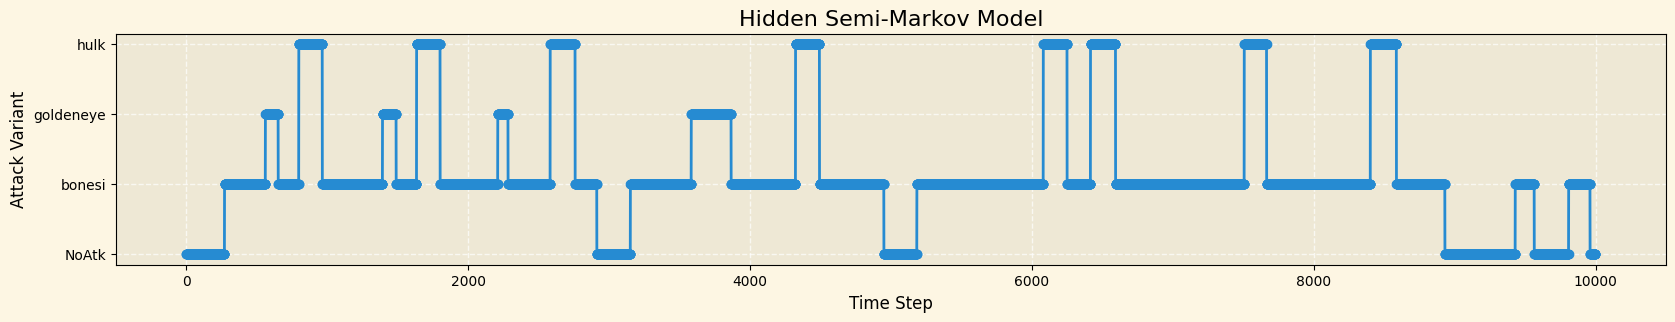

In [22]:
atk_states = ["NoAtk", "bonesi", "goldeneye", "hulk"]
atk_duration_means = np.array([5, 3, 6, 8])*30  # mean duration for each state (Poisson distribution)
atk_transition_matrix = np.array(  [[0.5, 0.2, 0.15, 0.15],  # No Attack
                                    [0.8, 0.2, 0.0, 0.0],  # DDoS
                                    [0.8, 0.0, 0.2, 0.0],  # SYN Flood
                                    [0.8, 0.0, 0.0, 0.2]])  # HTTP Flood   run_for = 10_000
for j in range(1): #Initialize Attackers
    atk_hsmm_states = generate_hsmm(run_for, atk_states, atk_duration_means, atk_transition_matrix, plot=True)
    intensity_sequence = generate_attack_intensity(
            run_for, baseline_intensity, fluctuation_intensity, spike_prob, spike_intensity,
            persistence_coeffs, decay_factor, drop_prob, drop_intensity
    )

### Streamer States

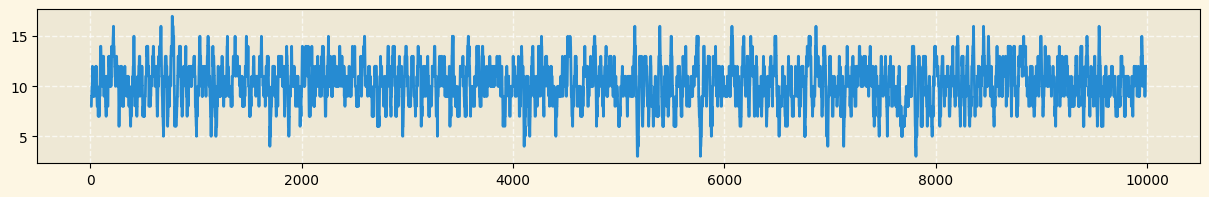

In [ ]:
from behavior import generate_hsmm
aggregate_state_sequence = np.zeros(10000)  
for j in range(18): #Initialize streamers
    hsmm_states = generate_hsmm(10000, stream_states, stream_duration_means, stream_transition_matrix)
    aggregate_state_sequence += hsmm_states
plt.figure(figsize=(15,2))

# plt.xlim(0,1000)
plt.plot(aggregate_state_sequence)
    

/home/vincent/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vincent/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/vincent/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vincent/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/vincent/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported

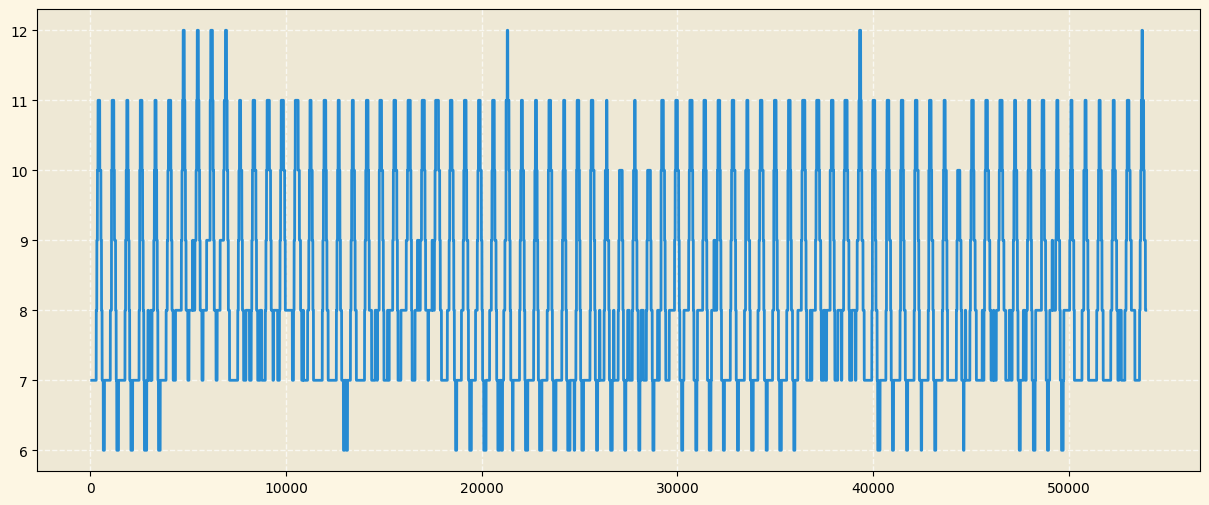

In [39]:
from behavior import user_behavior_from_csv
run_for=50_000
order, seasonal_order = (2,0,1), (1, 0, 1, 24) #Biggo and YT
biggo_model = user_behavior_from_csv("biggo", run_for, plot=False)
youtube_model = user_behavior_from_csv("youtube", run_for, plot=False)

order, seasonal_order = (1,0,1), (0, 0, 0, 24) #SteamTV
steamtv_model = user_behavior_from_csv("steamtv", run_for, plot=False)
plt.figure(figsize=(15,6))
# plt.plot(biggo_model+youtube_model+steamtv_model)
plt.plot(youtube_model)
# plt.xlim(0,1000)
plt.show()

In [ ]:
10000//110

90

In [ ]:
120*90

10800

/var/folders/fy/9jbbbrm52gjb_tgk0yfq90c40000gn/T/ipykernel_5408/1399393152.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap("seismic", 4)  # Get 4 colors from the 'seismic' colormap


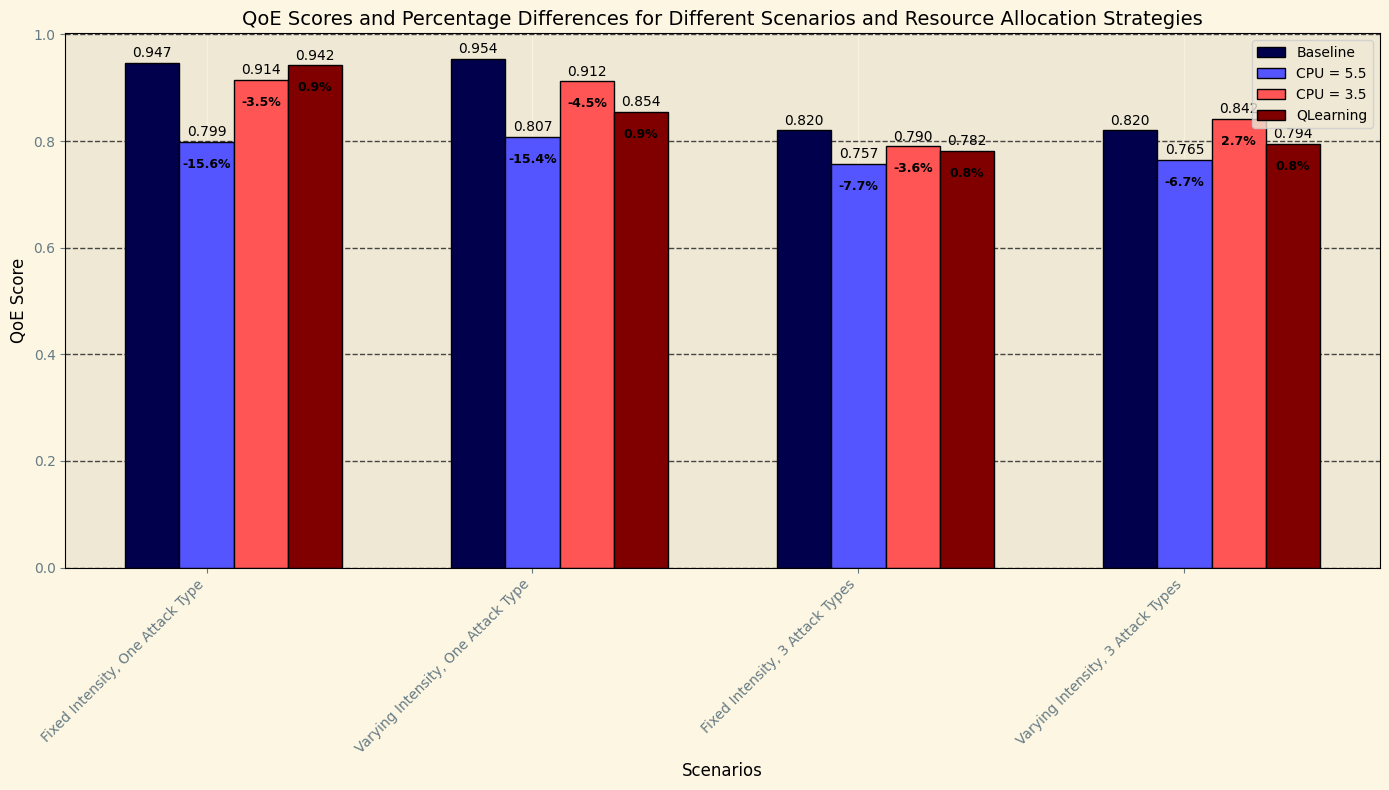

In [ ]:
# Modify the code to add spacing between each scenario type for clarity
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Define the scenarios and QoE scores for each resource allocation strategy
scenarios = [
    "Fixed Intensity, One Attack Type",
    "Varying Intensity, One Attack Type",
    "Fixed Intensity, 3 Attack Types",
    "Varying Intensity, 3 Attack Types"
]
plt.style.use("Solarize_Light2")

# QoE scores for each resource allocation strategy
baseline_qoe = [0.9471, 0.9543, 0.8199, 0.8199]
cpu_5_5_qoe = [0.7989, 0.8075, 0.7568, 0.7647]
# cpu_3_5_qoe = [0.9144, 0.9417, 0.7901, 0.8417]
cpu_3_5_qoe = [0.9144, 0.9117, 0.7901, 0.8417]
# QLearning = [0.94189, 0.7742, 0.7820, 0.79421]
QLearning = [0.94189, 0.8542, 0.7820, 0.79421]

# Adjust spacing by adding extra room between each group of bars
x = np.arange(len(scenarios)) * 1.5  # increase the spacing between scenarios
width = 0.25  # width of the bars

# Calculate percentage differences for annotation
def calculate_percentage_diff(reference, values):
    return [100 * (val - reference[i]) / reference[i] for i, val in enumerate(values)]

# Calculate percentage differences with Baseline as reference
cpu_5_5_diff = calculate_percentage_diff(baseline_qoe, cpu_5_5_qoe)
cpu_3_5_diff = calculate_percentage_diff(baseline_qoe, cpu_3_5_qoe)

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8))
color_map = cm.get_cmap("seismic", 4)  # Get 4 colors from the 'seismic' colormap

# Plot each resource allocation strategy
bars1 = ax.bar(x - width, baseline_qoe, width, label="Baseline", color=color_map(0), edgecolor="black")
bars2 = ax.bar(x, cpu_5_5_qoe, width, label="CPU = 5.5", color=color_map(1), edgecolor="black")
bars3 = ax.bar(x + width, cpu_3_5_qoe, width, label="CPU = 3.5", color=color_map(2), edgecolor="black")
bars4 = ax.bar(x + 2*width, QLearning, width, label="QLearning", color=color_map(3), edgecolor="black")

# Annotate each bar with the QoE score
for i in range(len(scenarios)):
    ax.text(x[i] - width, baseline_qoe[i] + 0.005, f"{baseline_qoe[i]:.3f}", ha='center', va='bottom', fontsize=10)
    ax.text(x[i], cpu_5_5_qoe[i] + 0.005, f"{cpu_5_5_qoe[i]:.3f}", ha='center', va='bottom', fontsize=10)
    ax.text(x[i] + width, cpu_3_5_qoe[i] + 0.005, f"{cpu_3_5_qoe[i]:.3f}", ha='center', va='bottom', fontsize=10)
    ax.text(x[i] + 2*width, QLearning[i] + 0.005, f"{QLearning[i]:.3f}", ha='center', va='bottom', fontsize=10)

# Annotate percentage difference for CPU = 5.5 and CPU = 3.5 relative to Baseline
for i in range(len(scenarios)):
    ax.text(x[i], cpu_5_5_qoe[i] - 0.03, f"{cpu_5_5_diff[i]:.1f}%", ha='center', va='top', color="black", fontsize=9, fontweight="bold")
    ax.text(x[i] + width, cpu_3_5_qoe[i] - 0.03, f"{cpu_3_5_diff[i]:.1f}%", ha='center', va='top', color="black", fontsize=9, fontweight="bold")
    ax.text(x[i] + 2*width, QLearning[i] - 0.03, f"{QLearning[i]:.1f}%", ha='center', va='top', color="black", fontsize=9, fontweight="bold")

# Labels, title, and legend
ax.set_xlabel("Scenarios", fontsize=12)
ax.set_ylabel("QoE Score", fontsize=12)
ax.set_title("QoE Scores and Percentage Differences for Different Scenarios and Resource Allocation Strategies", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(scenarios, rotation=45, ha="right")
ax.legend()

# Add black grid lines for readability
ax.grid(axis="y", linestyle="--", color="black", alpha=0.7)
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')

# Show plot with tight layout
plt.tight_layout()
plt.show()

/var/folders/fy/9jbbbrm52gjb_tgk0yfq90c40000gn/T/ipykernel_5408/1137917998.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap("seismic", 4)  # Get 4 colors from the 'seismic' colormap


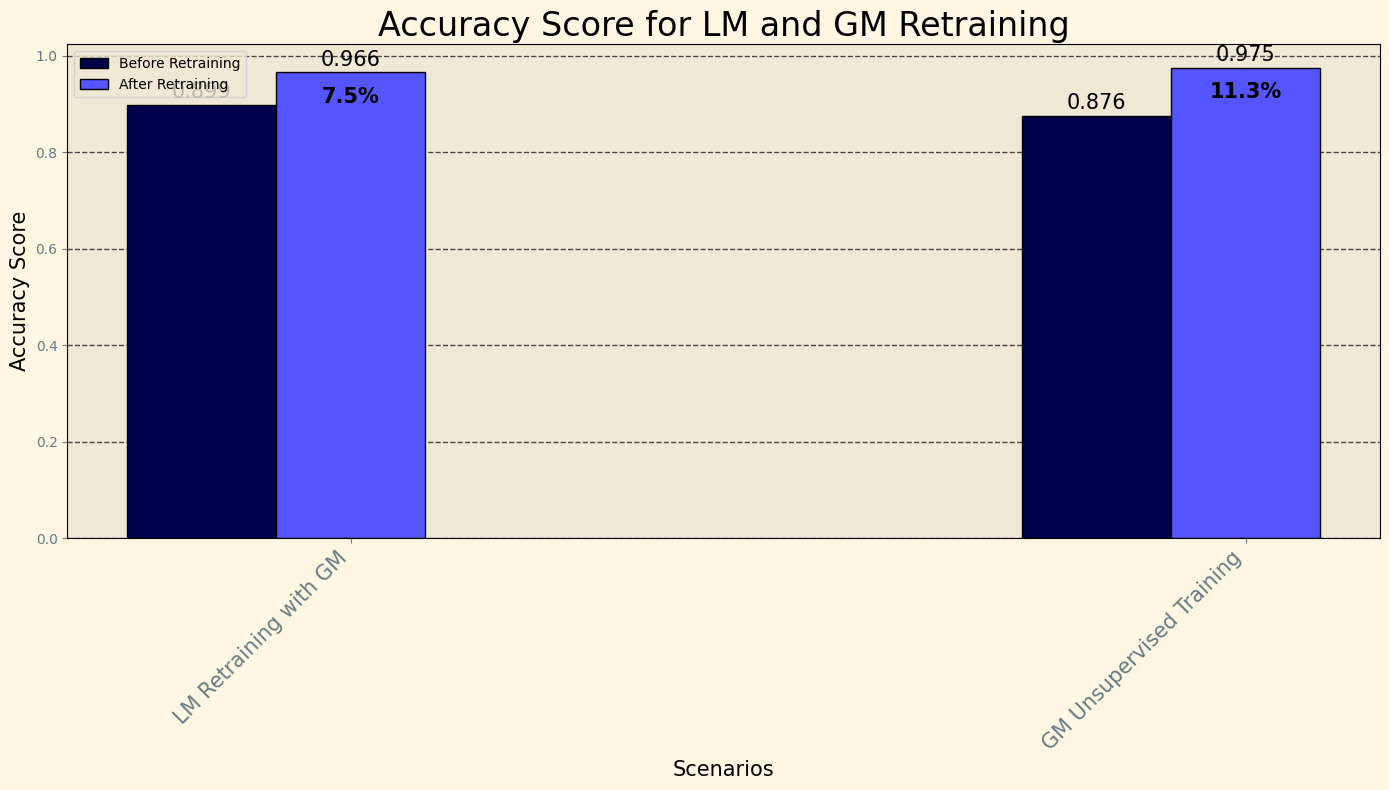

In [ ]:
# Modify the code to add spacing between each scenario type for clarity
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Define the scenarios and QoE scores for each resource allocation strategy
scenarios = [
    "LM Retraining with GM",
    "GM Unsupervised Training",
]
plt.style.use("Solarize_Light2")

# QoE scores for each resource allocation strategy
baseline_qoe = [0.899, 0.876]
cpu_5_5_qoe = [0.966, 0.975]

# Adjust spacing by adding extra room between each group of bars
x = np.arange(len(scenarios)) * 1.5  # increase the spacing between scenarios
width = 0.25  # width of the bars

# Calculate percentage differences for annotation
def calculate_percentage_diff(reference, values):
    return [100 * (val - reference[i]) / reference[i] for i, val in enumerate(values)]

# Calculate percentage differences with Baseline as reference
cpu_5_5_diff = calculate_percentage_diff(baseline_qoe, cpu_5_5_qoe)

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8))
color_map = cm.get_cmap("seismic", 4)  # Get 4 colors from the 'seismic' colormap

# Plot each resource allocation strategy
bars1 = ax.bar(x - width, baseline_qoe, width, label="Before Retraining", color=color_map(0), edgecolor="black")
bars2 = ax.bar(x, cpu_5_5_qoe, width, label="After Retraining", color=color_map(1), edgecolor="black")

# Annotate each bar with the QoE score
for i in range(len(scenarios)):
    ax.text(x[i] - width, baseline_qoe[i] + 0.005, f"{baseline_qoe[i]:.3f}", ha='center', va='bottom', fontsize=15)
    ax.text(x[i], cpu_5_5_qoe[i] + 0.005, f"{cpu_5_5_qoe[i]:.3f}", ha='center', va='bottom', fontsize=15)

# Annotate percentage difference for CPU = 5.5 and CPU = 3.5 relative to Baseline
for i in range(len(scenarios)):
    ax.text(x[i], cpu_5_5_qoe[i] - 0.03, f"{cpu_5_5_diff[i]:.1f}%", ha='center', va='top', color="black", fontsize=15, fontweight="bold")

# Labels, title, and legend
ax.set_xlabel("Scenarios", fontsize=15, color='black')
ax.set_ylabel("Accuracy Score", fontsize=15, color='black')
ax.set_title("Accuracy Score for LM and GM Retraining", fontsize=24)
ax.set_xticks(x)
ax.set_xticklabels(scenarios, rotation=45, ha="right", fontsize=15)
ax.legend()

# Add black grid lines for readability
ax.grid(axis="y", linestyle="--", color="black", alpha=0.7)
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')

# Show plot with tight layout
plt.tight_layout()
plt.show()

# Task Offloading

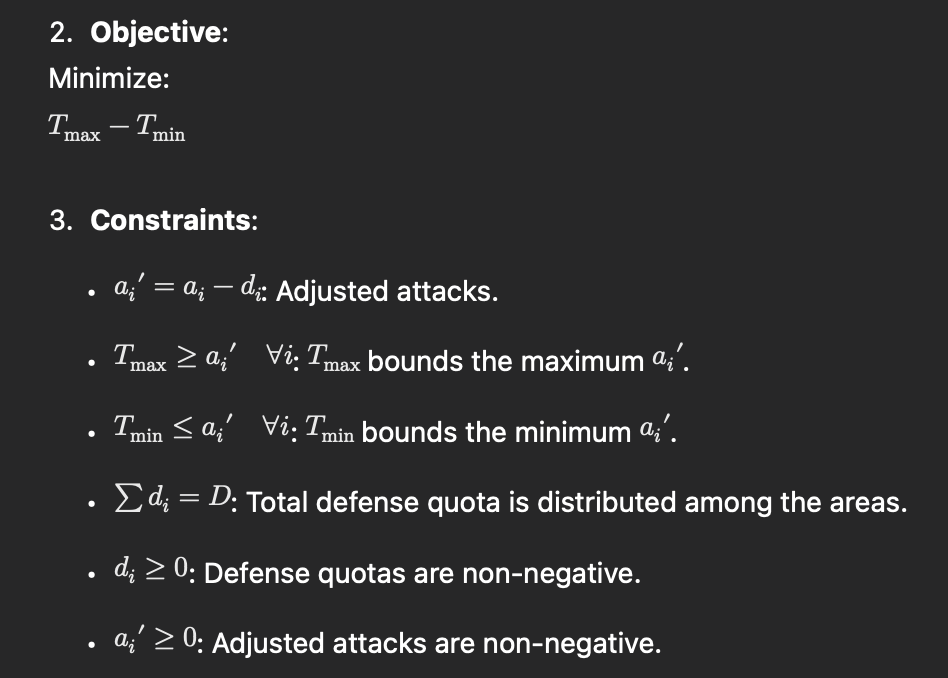

In [ ]:
from scipy.optimize import linprog
import numpy as np

def minimize_attack_difference(a, D):
    """
    Minimize the difference between max(a') and min(a') after allocating defense quotas.

    Parameters:
        a (list): Number of incoming attacks for each edge area.
        D (float): Total defense quota available for allocation.

    Returns:
        dict: Optimized adjusted attack values (a'), defense allocation (d), and max-min difference.
    """
    n = len(a) # Number of Edge Area
    obj = np.array(a) - np.ones(n)
    
    lhs_ineq = [[1]*n]    
    rhs_ineq = a
    
    lhs_eq = [[1]*n]
    rhs_eq = D
    bnd = [(0, float("inf")) * n]  # Bounds of d_i for all i
    

    # Solve the linear program
    result = linprog(c=obj, A_ub = lhs_ineq, b_ub = rhs_ineq, A_eq = lhs_eq, b_eq = rhs_eq, bounds=bnd, method="highs")

    if result.success:
        d = result.x[:n]  # Extract d_i values
        a_prime = result.x[n:2 * n]  # Extract a_i' values
        T_max = result.x[-2]
        T_min = result.x[-1]
        return {
            "a_prime": a_prime,
            "d": d,
            "max_min_difference": T_max - T_min,
            "T_max": T_max,
            "T_min": T_min,
        }
    else:
        raise ValueError("Optimization failed:", result.message)

# Example usage
a = [20, 40, 60, 30]  # Number of incoming attacks
D = 50  # Total defense quota

result = minimize_attack_difference(a, D)
print("Optimized adjusted attacks (a'):", result["a_prime"])
print("Defense allocation (d):", result["d"])
print("Max-Min Difference:", result["max_min_difference"])

ValueError: Invalid input for linprog: b_ub must be a 1-D array; b_ub must not have more than one non-singleton dimension and the number of rows in A_ub must equal the number of values in b_ub

In [ ]:
import numpy as np

def equalize_remaining_attacks(a, D):
    # total_quota = sum(remaining_quotas)
    total_quota = D    
    remaining_intensity = a
    total_atk = sum(a)

    z_prime = (remaining_intensity - total_quota)  / len(a)
    a_prime = remaining_intensity.copy()
    n=0
    while True:
        defense_allocation = np.zeros_like(a)
        # Find indices where remaining intensity exceeds z_prime
        idx_to_reduce = np.where(a_prime >= z_prime)[0]
        if len(idx_to_reduce) == 0:
            break  # No areas left to reduce
        # Update z' considering only these indices
        z_prime = max(0, (sum(a_prime[idx_to_reduce]) - total_quota) / len(idx_to_reduce))

        # Update defense allocation for these indices
        defense_allocation[idx_to_reduce] = a_prime[idx_to_reduce] - z_prime

        n+=1
        print(a_prime)
        print(defense_allocation)
        # Check termination condition
        if np.all(defense_allocation >= 0):
            break

        if n>10:

            break

    # Final outputs
    print("Defense Allocation:", defense_allocation)
    print("Remaining Attack Intensities After Allocation:", a_prime - defense_allocation)

# Example usage
d = np.array([100, 0, 0, 10, 0, 0, 0])
a = np.array([20, 40, 60, 20, 20, 0, 0])  # Originally
D = 50000
# Total defense quota
equalize_remaining_attacks(a, D)

[20 40 60 20 20  0  0]
[20 40 60 20 20  0  0]
Defense Allocation: [20 40 60 20 20  0  0]
Remaining Attack Intensities After Allocation: [0 0 0 0 0 0 0]


In [ ]:
min(0,1,1)

0

In [ ]:
def equalize_remaining_attacks(a, D):
    n = len(a)  # Number of edge areas
    
    

    # Compute z (remaining attacks for all areas)
    total_attacks = np.sum(a)
    z = (total_attacks - D) / n
    # z = min(z, min(a))
    # Compute d_i (defense allocation for each area)
    d = [ai - z for ai in a]
    print(z)
    a_prime = [z] * n
    # Ensure non-negativity of d_i and z
    if any(di < 0 for di in d) or z < 0:
        print(d)
        d = a*D/total_attacks
        a_prime = a-d
        
        

    # Compute remaining attacks a'
    

    return {
        "d": d,
        "z": z,
        "a_prime": a_prime,
        "total_remaining_attacks": sum(a_prime),
        "total_defense_allocated": sum(d),
    }

# Example usage
a = np.array([20, 40, 60, 10, 0, 0])  # Originally
a = np.array([20, 40, 60])  # Eliminate < D/n'
D = 60  # Total defense quota

result = equalize_remaining_attacks(a, D)
print("Defense allocation (d):", result["d"])
print("Remaining attacks (z):", result["z"])
print("Individual remaining attacks (a'):", np.round(result["a_prime"]))
print("Total remaining attacks:", result["total_remaining_attacks"])
print("Total defense allocated:", result["total_defense_allocated"])

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: 80.0
              x: [ 4.000e+01  0.000e+00  5.000e+01  1.000e+01  0.000e+00
                   0.000e+00  0.000e+00  0.000e+00  0.000e+00  3.000e+01
                   0.000e+00  5.000e+01]
            nit: 6
          lower:  residual: [ 4.000e+01  0.000e+00  5.000e+01  1.000e+01
                              0.000e+00  0.000e+00  0.000e+00  0.000e+00
                              0.000e+00  3.000e+01  0.000e+00  5.000e+01]
                 marginals: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00
                              2.000e+00  2.000e+00  2.000e+00  2.000e+00
                              0.000e+00  0.000e+00  0.000e+00  0.000e+00]
          upper:  residual: [       inf        inf        inf        inf
                                    inf        inf        inf        inf
                                    inf        inf        inf   